In [ ]:
import math
import sys
import random
from dataclasses import dataclass
import time
import argparse
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
# from sklearn.preprocessing import StandardScaler
import copy
# from hybrid_q_gp_cost import HybridQWithGPCost
 # adjust if needed
from cpo_agent_safepo_style import CPOConfig, CPOAgent
from ActSafeAgent import ActSafeAgent, ActSafeConfig
from safe_fqi import SafeFQI,collect_epoch_safe_fqi
from torch.distributions.kl import kl_divergence

from dataclasses import dataclass
from typing import Tuple, Dict, Deque
import json
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# import gymnasium as gym
import safety_gymnasium as sg
from tqdm import trange
# from schedules import AnnealScheduler, Anneal
# import gpytorch
from scipy.linalg import solve
# from gpytorch.kernels import RBFKernel,ScaleKernel,LinearKernel
# from sklearn.gaussian_process import GaussianProcessRegressor
# from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from collections import namedtuple, deque


In [20]:
safety_bound=0.3
epsilon_start = 1.0
epsilon_end = 0.02
epsilon_decay_rate = 0.9985
max_steps_per_test_episode=200
num_episodes = 2000
max_steps_per_episode = 200
test_episodes = 100
gamma = 0.99
lr = 0.0025
buffer_size = 50000
buffer = deque(maxlen=buffer_size)
batch_size = 100
penalty=60

In [21]:
def combined_shape(n, shape):
    if np.isscalar(shape):
        return (n, shape)
    return (n, *shape)

def to_tensor(x, device):
    if isinstance(x, np.ndarray):
        return torch.as_tensor(x, dtype=torch.float32, device=device)
    return torch.tensor(x, dtype=torch.float32, device=device)

def flat_params(model):
    return torch.cat([p.data.view(-1) for p in model.parameters()])

def flat_grad(grads):
    return torch.cat([g.contiguous().view(-1) for g in grads])

def set_params_from_flat(model, flat):
    idx = 0
    for p in model.parameters():
        n = p.numel()
        p.data.copy_(flat[idx:idx+n].view_as(p))
        idx += n

def count_parameters(module):
    return sum(p.numel() for p in module.parameters() if p.requires_grad)

class RunningNorm:
    """Keeps running mean/var for feature normalization."""
    def __init__(self, dim, eps=1e-8):
        self.dim = dim
        self.mean = np.zeros(dim, dtype=np.float64)
        self.var = np.ones(dim, dtype=np.float64)
        self.count = eps
        self.eps = eps

    def update(self, x_np: np.ndarray):
        x = x_np.reshape(-1, self.dim).astype(np.float64)
        batch_mean = x.mean(axis=0)
        batch_var = x.var(axis=0)
        batch_count = x.shape[0]

        delta = batch_mean - self.mean
        tot_count = self.count + batch_count

        new_mean = self.mean + delta * batch_count / tot_count
        m_a = self.var * self.count
        m_b = batch_var * batch_count
        M2 = m_a + m_b + delta**2 * self.count * batch_count / tot_count
        new_var = M2 / (tot_count)

        self.mean = new_mean
        self.var = np.maximum(new_var, self.eps)
        self.count = tot_count

    def normalize_torch(self, x: torch.Tensor):
        m = torch.as_tensor(self.mean, dtype=x.dtype, device=x.device)
        s = torch.as_tensor(self.var, dtype=x.dtype, device=x.device).sqrt()
        return (x - m) / (s + 1e-8)
    
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hidden=(64, 64), act=nn.Tanh, out_act=None):
        super().__init__()
        layers = []
        last = in_dim
        for h in hidden:
            layers += [nn.Linear(last, h), act()]
            last = h
        layers.append(nn.Linear(last, out_dim))
        if out_act:
            layers.append(out_act())
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

class GaussianPolicy(nn.Module):
    """
    Tanh-squashed diagonal Gaussian policy for continuous actions.
    KL is computed in pre-tanh Gaussian space.
    """
    def __init__(self, obs_dim, act_dim, hidden=(64,64), log_std_init=-1):
        super().__init__()
        self.mu_net = MLP(obs_dim, act_dim, hidden, act=nn.Tanh)
        self.log_std = nn.Parameter(torch.ones(act_dim) * log_std_init)
        with torch.no_grad():
            self.log_std.clamp_(-5.0, 2.0)
    def _dist(self, obs):
        mu  = self.mu_net(obs)
        std = torch.exp(self.log_std)
        return mu, std

    @staticmethod
    def atanh(x, eps=1e-6):
        return 0.5 * (torch.log1p(x + eps) - torch.log1p(-x + eps))

    def log_prob_from_u(self, u, mu, std, a):
        pre_sum = -0.5 * (((u - mu) / (std + 1e-8)) ** 2 + 2 * torch.log(std + 1e-8) + math.log(2 * math.pi))
        logp_u = pre_sum.sum(dim=-1)
        logdet_jac = torch.log(1 - a.pow(2) + 1e-8).sum(dim=-1)
        return logp_u - logdet_jac

    def sample(self, obs):
        mu, std = self._dist(obs)
        eps = torch.randn_like(mu)
        u = mu + std * eps
        a = torch.tanh(u)
        logp = self.log_prob_from_u(u, mu, std, a)
        return a, logp, u, mu, std

    def log_prob(self, obs, a):
        mu, std = self._dist(obs)
        u = self.atanh(a)
        return self.log_prob_from_u(u, mu, std, a)

    def kl_with(self, other, obs):
        mu0, std0 = other._dist(obs)
        mu1, std1 = self._dist(obs)
        kl = (torch.log(std1 + 1e-8) - torch.log(std0 + 1e-8)
              + (std0**2 + (mu0 - mu1)**2) / (2 * (std1**2) + 1e-8) - 0.5).sum(dim=-1)
        return kl.mean()


    def forward(self, obs):
        # return a Normal in pre-tanh space
        mu, std = self._dist(obs)     # your existing helper
        return torch.distributions.Normal(mu, std)
    def mean_kl(self, other, obs) -> torch.Tensor:
    # KL(self || other) averaged over batch
    # (our kl_with computes KL(other || self), so flip the order)
        return other.kl_with(self, obs)

class ValueNet(nn.Module):
    def __init__(self, obs_dim, hidden=(64, 64)):
        super().__init__()
        self.v = MLP(obs_dim, 1, hidden, act=nn.Tanh)
    def forward(self, obs):
        return self.v(obs).squeeze(-1)

# ============================================================
# Buffer with reward & cost GAE
# ============================================================

class GAEBuffer:
    def __init__(self, obs_space, act_space, size, gamma=0.99, lam=0.95, gamma_c=1, lam_c=0.95, device='cpu'):
        self.obs_buf  = np.zeros(combined_shape(size, obs_space.shape), dtype=np.float32)
        self.act_buf  = np.zeros(combined_shape(size, act_space.shape), dtype=np.float32)
        self.rew_buf  = np.zeros(size, dtype=np.float32)
        self.cost_buf = np.zeros(size, dtype=np.float32)
        self.val_buf  = np.zeros(size, dtype=np.float32)
        self.cval_buf = np.zeros(size, dtype=np.float32)
        self.logp_buf = np.zeros(size, dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)

        self.gamma, self.lam = gamma, lam
        self.gamma_c, self.lam_c = gamma_c, lam_c
        self.ptr, self.path_start_idx, self.max_size = 0, 0, size
        self.device = device

    def reset(self):
        self.ptr = 0
        self.path_start_idx = 0

    def store(self, obs, act, rew, cost, val, cval, logp, done):
        assert self.ptr < self.max_size
        self.obs_buf[self.ptr]  = obs
        self.act_buf[self.ptr]  = act
        self.rew_buf[self.ptr]  = rew
        self.cost_buf[self.ptr] = cost
        self.val_buf[self.ptr]  = val
        self.cval_buf[self.ptr] = cval
        self.logp_buf[self.ptr] = logp
        self.done_buf[self.ptr] = done
        self.ptr += 1

    def _gae_like(self, deltas, gamma, lam):
        adv = np.zeros_like(deltas, dtype=np.float32)
        gae = 0.0
        for t in reversed(range(len(deltas))):
            gae = deltas[t] + gamma * lam * gae
            adv[t] = gae
        return adv

    def finish_path(self, last_val, last_cval):
        path_slice = slice(self.path_start_idx, self.ptr)

        rews  = np.append(self.rew_buf[path_slice],  last_val)
        costs = np.append(self.cost_buf[path_slice], last_cval)
        vals  = self.val_buf[path_slice]
        cvals = self.cval_buf[path_slice]

        deltas  = rews[:-1]  + self.gamma   * np.append(vals[1:],  last_val)  - vals
        cdelta  = costs[:-1] + self.gamma_c * np.append(cvals[1:], last_cval) - cvals

        adv_r = self._gae_like(deltas, self.gamma, self.lam)
        adv_c = self._gae_like(cdelta,  self.gamma_c, self.lam_c)

        ret_r = adv_r + vals
        ret_c = adv_c + cvals

        self.adv_r_buf = getattr(self, "adv_r_buf", np.zeros_like(self.rew_buf))
        self.adv_c_buf = getattr(self, "adv_c_buf", np.zeros_like(self.cost_buf))
        self.ret_r_buf = getattr(self, "ret_r_buf", np.zeros_like(self.rew_buf))
        self.ret_c_buf = getattr(self, "ret_c_buf", np.zeros_like(self.cost_buf))

        self.adv_r_buf[path_slice] = adv_r
        self.adv_c_buf[path_slice] = adv_c
        self.ret_r_buf[path_slice] = ret_r
        self.ret_c_buf[path_slice] = ret_c

        self.path_start_idx = self.ptr

    def get(self):
        assert self.ptr == self.max_size

        adv_r = self.adv_r_buf
        adv_r = (adv_r - adv_r.mean()) / (adv_r.std() + 1e-8)
        adv_c = self.adv_c_buf
        adv_c = adv_c / (adv_c.std() + 1e-8)
        # adv_c = (adv_c - adv_c.mean()) / (adv_c.std() + 1e-8)
        data = dict(
            obs   = to_tensor(self.obs_buf,   self.device),
            act   = to_tensor(self.act_buf,   self.device),
            logp  = to_tensor(self.logp_buf,  self.device),
            adv_r = to_tensor(adv_r,          self.device),
            adv_c = to_tensor(adv_c,          self.device),
            # adv_c = to_tensor(self.adv_c_buf, self.device),
            ret_r = to_tensor(self.ret_r_buf, self.device),
            ret_c = to_tensor(self.ret_c_buf, self.device),
        )
        return data



In [22]:
# class hybridBuffer:
#     def __init__(self, obs_dim, act_dim, capacity=1_000_000, seed=0):
#         self.n = capacity
#         rng = np.random.default_rng(seed)
#         self.rng = rng
#         self.ptr = 0
#         self.size = 0
#         self.obs      = np.zeros((capacity, obs_dim), dtype=np.float32)
#         self.next_obs = np.zeros((capacity, obs_dim), dtype=np.float32)
#         self.act      = np.zeros((capacity, act_dim), dtype=np.float32)
#         self.rew      = np.zeros((capacity, 1), dtype=np.float32)
#         self.cost     = np.zeros((capacity, 1), dtype=np.float32)
#         self.done     = np.zeros((capacity, 1), dtype=np.float32)

#     def add(self, obs, act, rew, cost, next_obs, done):
#         i = self.ptr
#         self.obs[i]      = obs
#         self.act[i]      = act
#         self.rew[i, 0]   = rew
#         self.cost[i, 0]  = cost
#         self.next_obs[i] = next_obs
#         self.done[i, 0]  = float(done)
#         self.ptr = (self.ptr + 1) % self.n
#         self.size = min(self.size + 1, self.n)

#     def get(self, batch_size=256, bias_cost_frac=0.0, cost_threshold=1e-6):
#         if bias_cost_frac <= 0.0 or (self.cost[:self.size] <= cost_threshold).all():
#             idx = self.rng.integers(0, self.size, size=batch_size)
#         else:
#             # cost-aware: draw a fraction from cost>0 and the rest uniform
#             cost_idx = np.flatnonzero(self.cost[:self.size, 0] > cost_threshold)
#             k = int(batch_size * bias_cost_frac)
#             if len(cost_idx) > 0 and k > 0:
#                 k = min(k, len(cost_idx))
#                 idx1 = self.rng.choice(cost_idx, size=k, replace=len(cost_idx) < k)
#                 idx2 = self.rng.integers(0, self.size, size=batch_size - k)
#                 idx = np.concatenate([idx1, idx2])
#             else:
#                 idx = self.rng.integers(0, self.size, size=batch_size)

#         return {
#             "obs":      self.obs[idx],
#             "act":      self.act[idx],
#             "rew":      self.rew[idx].squeeze(-1),
#             "cost":     self.cost[idx].squeeze(-1),
#             "next_obs": self.next_obs[idx],
#             "done":     self.done[idx].squeeze(-1),
#         }

In [23]:

# ---------- tiny utils (self-contained; do not rely on globals) ----------

def _flat_params(module: nn.Module) -> torch.Tensor:
    return torch.cat([p.data.view(-1) for p in module.parameters()])

def _set_flat_params(module: nn.Module, flat: torch.Tensor) -> None:
    idx = 0
    for p in module.parameters():
        n = p.numel()
        p.data.copy_(flat[idx:idx+n].view_as(p))
        idx += n

def _flat_grad(loss: torch.Tensor, params, retain_graph=False, create_graph=False) -> torch.Tensor:
    grads = torch.autograd.grad(loss, params, retain_graph=retain_graph, create_graph=create_graph)
    return torch.cat([g.contiguous().view(-1) for g in grads])

def _to_tensor(x, device):
    if isinstance(x, torch.Tensor):
        return x.to(device)
    x = np.asarray(x)
    return torch.as_tensor(x, dtype=torch.float32, device=device)




In [24]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=64):
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.to(device)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)
    
class ReplayBuffer:
    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    # def sample(self):
    #     experiences = random.sample(self.memory, k=self.batch_size)

    #     states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
    #     actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
    #     rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
    #     next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
    #     dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

    #     return (states, actions, rewards, next_states, dones)
    def sample(self, batch_size, device="cpu"):
        n = len(self.experience)
        idx = np.random.randint(0, n, size=batch_size)

        # assume storage[i] is a dict with keys below
        def cat(key, dtype=None):
            arr = np.stack([self.experience[i][key] for i in idx], axis=0)
            t = torch.from_numpy(arr)
            if dtype is not None: t = t.to(dtype)
            # pin + non_blocking helps GPU transfer
            if device.type == "cuda":
                t = t.pin_memory().to(device, non_blocking=True)
            else:
                t = t.to(device)
            return t

        S  = cat("obs",       torch.float32)
        A  = cat("act",       torch.float32)
        R  = cat("rew",       torch.float32).squeeze(-1)
        # C  = cat("cost",      torch.float32).squeeze(-1)
        S2 = cat("next_obs",  torch.float32)
        D  = cat("done",      torch.float32).squeeze(-1)

        return S, A, R,  S2, D

    def __len__(self):
        return len(self.memory)
    
class DQNAgent:
    # Initialize the DQN agent
    def __init__(self, state_size, action_size, seed, lr):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr)

        self.memory = ReplayBuffer(action_size, buffer_size=int(1e5), batch_size=64, seed=seed)
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)

        self.t_step = (self.t_step + 1) % 4
        if self.t_step == 0:
            if len(self.memory) > 64:
                experiences = self.memory.sample()
                self.learn(experiences, gamma=0.99)

    # Choose an action based on the current state
    def act(self, state, eps=0.):
        state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(device)
        
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state_tensor)
        self.qnetwork_local.train()

        if np.random.random() > eps:
            return action_values.argmax(dim=1).item()
        else:
            return np.random.randint(self.action_size)
        
    # Choose an safe action based on the current state and prediction
    def act_safe(self, state, model, CI_para, eps=0):
        state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(device)
        
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state_tensor)
        self.qnetwork_local.train()
        
        possible_action=np.ones(self.action_size)
        for i in range(self.action_size):
            X=np.concatenate((state, np.array(i).reshape(1, )), axis=0)
            X_tensor=torch.from_numpy(X).float().unsqueeze(0).to(device)
            mean, log_var = model(X_tensor)
            ub= mean.item()+CI_para*np.sqrt(np.exp(log_var.item()))
            if ub>=safety_bound:
                possible_action[i]=0 
                # action_values[0][i]=-1
               
        if np.random.random() > eps:
            return action_values.argmax(dim=1).item()
        else:

            if np.sum(possible_action)==0:
                return action_values.argmax(dim=1).item()
            else:
                a=np.random.choice(self.action_size,size=1,p=possible_action/np.sum(possible_action))[0]
                return int(a)
            # return np.random.randint(self.action_size)
    # Learn from batch of experiences
    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = zip(*experiences)
        states = torch.from_numpy(np.vstack(states)).float().to(device)
        actions = torch.from_numpy(np.vstack(actions)).long().to(device)
        rewards = torch.from_numpy(np.vstack(rewards)).float().to(device)
        next_states = torch.from_numpy(np.vstack(next_states)).float().to(device)
        dones = torch.from_numpy(np.vstack(dones).astype(np.uint8)).float().to(device)

        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        Q_expected = self.qnetwork_local(states).gather(1, actions)

        loss = F.mse_loss(Q_expected, Q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.soft_update(self.qnetwork_local, self.qnetwork_target, tau=1e-3)

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)
    
class ProbabilisticRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim=128,init_log_var=0.0):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU()
        )
        self.mean_head = nn.Linear(hidden_dim, 1)
        self.log_var_head = nn.Linear(hidden_dim, 1)  # log variance for stability
        nn.init.constant_(self.log_var_head.bias, init_log_var)# start with σ^2 ~ e^{init_log_var}

    def forward(self, x):
        h = self.shared(x)
        mean = self.mean_head(h)
        log_var = self.log_var_head(h)
        return mean, log_var  # we return log variance to keep it numerically stable
    

def gaussian_nll_loss(mean, log_var, y, weight=None):
    # per-sample loss:
    loss_per = 0.5 * (log_var + (y - mean) ** 2 / torch.exp(log_var))
    if weight is not None:
        w = weight
        loss = (loss_per * w).sum() / (w.sum() + 1e-8)
    else:
        loss = loss_per.mean()
    return loss

class CostReplay:
    def __init__(self, maxlen=200_000, device='cpu'):
        self.mem: Deque[tuple] = deque(maxlen=maxlen)
        self.device = device
    def add(self, s: np.ndarray, a: np.ndarray, c: float):
        self.mem.append( (np.asarray(s, dtype=np.float32),
                          np.asarray(a, dtype=np.float32),
                          float(c)) )
    def sample(self, batch_size: int):
        if len(self.mem) == 0: return None
        batch = random.sample(self.mem, k=min(batch_size, len(self.mem)))
        S = torch.as_tensor(np.stack([b[0] for b in batch]), dtype=torch.float32, device=self.device)
        A = torch.as_tensor(np.stack([b[1] for b in batch]), dtype=torch.float32, device=self.device)
        C = torch.as_tensor(np.stack([b[2] for b in batch]), dtype=torch.float32, device=self.device).unsqueeze(1)
        return S, A, C
    def __len__(self): return len(self.mem)  

In [25]:


# class HybridAgent:
#     def __init__(self, obs_space, act_space, device="cpu"):
#         self.device = device
#         self.core = HybridQWithGPCost(obs_space.shape[0], act_space.shape[0], device=device)

#     def update(self, data, ep_cost_mean: float, cost_limit: float, avg_ep_len: float):
#         # Delegate to core and softly update targets
#         self.core.update(data)
#         self.core.soft_update_(self.core.q1, self.core.q1_t)
#         self.core.soft_update_(self.core.q2, self.core.q2_t)
#         return {"updates": 1}


def collect_epoch_hybrid(env, agent, steps_per_epoch, device):
    o, info = env.reset()
    obs_l, act_l, rew_l, cost_l, next_l, done_l = [], [], [], [], [], []
    ep_costs, ep_rewards = [], []
    ep_ret, ep_cost, ep_len = 0.0, 0.0, 0
    unsafe_steps, num_eps = 0, 0
    explore_prob=0.3
    new_explore_prob=0.05
    for _ in range(steps_per_epoch):
        obs_np = o.astype(np.float32)
        if np.random.rand() < explore_prob and agent.core.global_step < agent.core._warmup:
            a_np = env.action_space.sample()
        
        else:
            if np.random.rand() < new_explore_prob: 
                a_np = env.action_space.sample()
            else:
                a_np = agent.core.select_action_safe(obs_np)

        step_out = env.step(a_np)
        if len(step_out) == 6:
            o2, r, c, terminated, truncated, info = step_out
        else:
            o2, r, terminated, truncated, info = step_out
            c = float(info.get('cost', 0.0))

        terminal = bool(terminated)
        trunc = bool(truncated)
        done = terminal or trunc

        obs_l.append(obs_np)
        act_l.append(a_np.astype(np.float32))
        rew_l.append(float(r))
        cost_l.append(float(c))
        next_l.append(o2.astype(np.float32))
        done_l.append(float(done))

        unsafe_steps += int(float(c) > 0.0)
        ep_len += 1
        ep_cost += float(c)
        ep_ret += float(r)
        o = o2

        if done:
            ep_costs.append(ep_cost)
            ep_rewards.append(ep_ret)
            num_eps += 1
            o, info = env.reset()
            ep_ret, ep_len, ep_cost = 0.0, 0, 0.0

    data = {
        "obs": np.stack(obs_l, axis=0),
        "act": np.stack(act_l, axis=0),
        "rew": np.array(rew_l, dtype=np.float32),
        "cost": np.array(cost_l, dtype=np.float32),
        "next_obs": np.stack(next_l, axis=0),
        "done": np.array(done_l, dtype=np.float32),
        "_unsafe_steps": int(unsafe_steps),
        "_episodes": int(max(1, num_eps))
    }

    ep_cost_mean = float(np.mean(ep_costs)) if len(ep_costs) > 0 else 0.0
    avg_ep_len = steps_per_epoch / max(1, num_eps)
    ep_reward_mean = float(np.mean(ep_rewards)) if len(ep_rewards) > 0 else 0.0

    return data, ep_cost_mean, avg_ep_len, ep_reward_mean


In [26]:
@dataclass
class GPQConfig:
    # Actor / Critic
    hidden: Tuple[int,int] = (64, 64)
    gamma: float = 0.99
    actor_lr: float = 3e-4
    critic_lr: float = 3e-4
    tau: float = 0.005                # soft target update
    actor_updates: int = 80
    critic_updates: int = 200
    batch_size: int = 256
    target_smooth_noise: float = 0.2  # optional target smoothing (set 0.0 to disable)
    target_smooth_clip: float = 0.5

    # Cost GP (neural)
    cost_lr: float = 1e-3
    cost_hidden: int = 128
    cost_pos_weight: float = 10.0
    var_floor: float = 0.05
    ci_start: float = 1
    ci_end: float = 0.5
    ci_decay: float = 0.995
    # Constraint enforcement - tuned for SafetyPointGoal2-v0
    lambda_lr: float = 0.05       # higher learning rate for point navigation task
    lambda_max = 10.0             # cap for strong constraint enforcement
    # Remove old parameters that are no longer used
    # alpha_ucb: float = 2.0         # not used in new design
    # actor_cost_penalty: float = 0.5 # not used in new design
    # Replay
    replay_size: int = 500_000
    safe_margin: float = 0.0         # hinge margin above cost_limit
    penalty_power: float = 2.0       # 1.0=linear, 2.0=quadratic
    clamp_ucb_max: float = 1.0       # cap UCB to [0, clamp_ucb_max]
    use_lambda_in_critic: bool = False
    lookahead_risk: bool = True      # also penalize next-state action risk
    adaptive_alpha: bool = True      # scale alpha by batch stds

    device: str = "cpu"

class TransitionReplay:
    def __init__(self, obs_dim, act_dim, maxlen=500_000, device='cpu'):
        self.mem: Deque[tuple] = deque(maxlen=maxlen)
        self.device = device
        self.obs_dim = obs_dim
        self.act_dim = act_dim
    def add(self, s, a, r, c, s2, d):
        self.mem.append((
            np.asarray(s,  dtype=np.float32),
            np.asarray(a,  dtype=np.float32),
            float(r), float(c),
            np.asarray(s2, dtype=np.float32),
            float(d)
        ))
    def __len__(self): return len(self.mem)
    def sample(self, batch_size: int):
        batch_size = min(batch_size, len(self.mem))
        idx = np.random.choice(len(self.mem), size=batch_size, replace=False)
        S  = torch.as_tensor(np.stack([self.mem[i][0] for i in idx]), dtype=torch.float32, device=self.device)
        A  = torch.as_tensor(np.stack([self.mem[i][1] for i in idx]), dtype=torch.float32, device=self.device)
        R  = torch.as_tensor(np.array([self.mem[i][2] for i in idx])[:,None], dtype=torch.float32, device=self.device)
        C  = torch.as_tensor(np.array([self.mem[i][3] for i in idx])[:,None], dtype=torch.float32, device=self.device)
        S2 = torch.as_tensor(np.stack([self.mem[i][4] for i in idx]), dtype=torch.float32, device=self.device)
        D  = torch.as_tensor(np.array([self.mem[i][5] for i in idx])[:,None], dtype=torch.float32, device=self.device)
        return S, A, R, C, S2, D

class QCritic(nn.Module):
    """Q(s,a) for continuous actions."""
    def __init__(self, obs_dim, act_dim, hidden=(64,64)):
        super().__init__()
        self.q = MLP(obs_dim + act_dim, 1, hidden, act=nn.ReLU)
    def forward(self, s, a):
        return self.q(torch.cat([s, a], dim=1))

class GPQAgent:
    """
    REDESIGNED GP-cost + Q-learning for SAFE continuous control.
    - Cost model: learns continuous cost function with uncertainty
    - Safe reward shaping: r' = r - penalty for constraint violations
    - Constraint enforcement: dual variable λ with proper ascent
    - Safe policy: ensures cost_limit is respected during training
    """
    def __init__(self, obs_space, act_space, cfg: GPQConfig):
        assert len(act_space.shape) == 1, "Continuous Box action space expected."
        self.cfg = cfg
        self.device = cfg.device
        print(f"[gpq] device={self.device}")

        self.obs_dim = obs_space.shape[0]
        self.act_dim = act_space.shape[0]

        # Policy (Gaussian for exploration; we use its mean for actor update)
        self.pi = GaussianPolicy(self.obs_dim, self.act_dim, hidden=cfg.hidden, log_std_init=-1).to(cfg.device)
        self.pi_target = GaussianPolicy(self.obs_dim, self.act_dim, hidden=cfg.hidden, log_std_init=-1).to(cfg.device)
        self.pi_target.load_state_dict(self.pi.state_dict())
        self.old_pi = GaussianPolicy(self.obs_dim, self.act_dim, hidden=cfg.hidden, log_std_init=-1).to(cfg.device)
        self.old_pi.load_state_dict(self.pi.state_dict())

        # Critic + target
        self.q = QCritic(self.obs_dim, self.act_dim, hidden=cfg.hidden).to(cfg.device)
        self.q_target = QCritic(self.obs_dim, self.act_dim, hidden=cfg.hidden).to(cfg.device)
        self.q_target.load_state_dict(self.q.state_dict())

        # Value heads (only so your runner/GAE works; we fit them to returns it provides)
        self.vf  = ValueNet(self.obs_dim, hidden=cfg.hidden).to(cfg.device)
        self.cvf = ValueNet(self.obs_dim, hidden=cfg.hidden).to(cfg.device)
        self.vf_opt  = torch.optim.Adam(self.vf.parameters(),  lr=3e-4)
        self.cvf_opt = torch.optim.Adam(self.cvf.parameters(), lr=3e-4)

        # Cost model (GP-like neural net)
        self.cost_model = ProbabilisticRegressor(self.obs_dim + self.act_dim, hidden_dim=cfg.cost_hidden).to(cfg.device)
        self.cost_opt   = torch.optim.Adam(self.cost_model.parameters(), lr=cfg.cost_lr)

        # Normalizers for (s,a) before cost model
        self.obs_norm = RunningNorm(self.obs_dim)
        self.act_norm = RunningNorm(self.act_dim)

        # Opts
        self.actor_opt  = torch.optim.Adam(self.pi.parameters(), lr=cfg.actor_lr)
        self.critic_opt = torch.optim.Adam(self.q.parameters(),  lr=cfg.critic_lr)

        # Replay
        self.replay = TransitionReplay(self.obs_dim, self.act_dim, maxlen=cfg.replay_size, device=cfg.device)

        # CI schedule
        self.ci = cfg.ci_start
        self.lambda_c = torch.tensor(1.0, device=self.device, dtype=torch.float32)  # dual variable for cost
        self.cost_limit = 5.0  # Match training cost limit

    # ---------- plumbing hooks for the runner ----------
    def _alpha_schedule(self):
        # No longer needed in new design - constraint enforcement via dual variable
        return 0.0
    
    def observe_transition(self, s, a, r, c, s2, done):
        # keep normalizers fresh for cost model inputs
        self.obs_norm.update(np.asarray(s, dtype=np.float32).reshape(1,-1))
        self.act_norm.update(np.asarray(a, dtype=np.float32).reshape(1,-1))
        self.replay.add(s, a, r, c, s2, done)

    def _ucb_cost(self, S, A):
        # normalize inputs to cost model
        S_n = self.obs_norm.normalize_torch(S)
        A_n = self.act_norm.normalize_torch(A)
        X = torch.cat([S_n, A_n], dim=1)
        mean, log_var = self.cost_model(X)
        var = torch.exp(log_var).clamp_min(1e-6)
        sigma = torch.sqrt(var)
        UCB = (mean + self.ci * sigma).clamp(0.0, 1.0)
        return UCB, mean.clamp(0.0, 1.0)

    def _soft_update(self, net, target):
        with torch.no_grad():
            for p, tp in zip(net.parameters(), target.parameters()):
                tp.mul_(1.0 - self.cfg.tau).add_(self.cfg.tau * p)

    def update(self, data: Dict, ep_cost_mean: float, cost_limit: float, avg_ep_len: float):
        """One epoch of updates using whatever is in replay + (optionally) fit vf/cvf to provided returns."""
        # Snapshot policy BEFORE any updates for KL logging
        self.old_pi.load_state_dict(self.pi.state_dict())
        B = self.cfg.batch_size
        updates_done = 0
        self.cost_limit = float(cost_limit)
        # ---------- critic + actor steps ----------
        if len(self.replay) >= max(2*B, 10000):  # warmup: require at least 10k transitions
            for _ in range(self.cfg.critic_updates):
                S, A, R, C, S2, D = self.replay.sample(B)

                # No reward shaping: critic target uses raw reward only
                with torch.no_grad():
                    mu2, _ = self.pi_target._dist(S2)
                    A2 = torch.tanh(mu2)
                    Q_targ = self.q_target(S2, A2)
                    Y = R + (1.0 - D) * self.cfg.gamma * Q_targ
                # --- risk for current and (optionally) next ---
                    
                # UCB_now, _ = self._ucb_cost(S, A)

                # with torch.no_grad():
                #     mu2, _ = self.pi_target._dist(S2)
                #     A2     = torch.tanh(mu2)
                #     UCB_next, _ = self._ucb_cost(S2, A2)

                # # Potential-based shaping: encourage moves to safer states
                # # NOTE: mask terminals so we don't add future risk at episode ends
                # delta_ucb = UCB_now - (1.0 - D) * self.cfg.gamma * UCB_next

                # # Scale gently; NO hinge, NO square here (keep it smooth)
                # alpha = self._alpha_schedule()  # see helper below
                # R_safe = R + alpha * delta_ucb.detach()

                # # (Optional but recommended) limit extremes to avoid exploding TD targets
                # R_safe = torch.clamp(R_safe, -5.0, 5.0)

                # with torch.no_grad():
                #     Q_targ = self.q_target(S2, A2)

                # Y = R_safe + (1.0 - D) * self.cfg.gamma * Q_targ


                # critic loss
                Q = self.q(S, A)
                critic_loss = F.mse_loss(Q, Y)
                self.critic_opt.zero_grad()
                critic_loss.backward()
                self.critic_opt.step()

                # Actor loss: maximize Q(s, pi(s)) with hinge constraint penalty per step
                mu, _ = self.pi._dist(S)
                A_det = torch.tanh(mu)
                q_value = self.q(S, A_det).mean()
                
                # Predicted per-step hazard in [0,1]
                _, mean_cost = self._ucb_cost(S, A_det)
                # Per-step budget threshold
                step_limit = torch.as_tensor(self.cost_limit / max(1.0, float(avg_ep_len)), device=S.device, dtype=mean_cost.dtype)
                hinge = F.relu(mean_cost - step_limit)
                
                # Actor objective: maximize reward Q, penalize only above per-step budget
                act_loss = -q_value + self.lambda_c * hinge.mean()
                
                # Small entropy bonus for exploration
                dist = self.pi(S)
                act_loss = act_loss - 1e-3 * dist.entropy().mean()
                
                self.actor_opt.zero_grad()
                act_loss.backward()
                self.actor_opt.step()

                # targets
                self._soft_update(self.q,  self.q_target)
                self._soft_update(self.pi, self.pi_target)
                self.total_updates = getattr(self, "total_updates", 0) + 1.
                updates_done += 1

                #     _, mean_c = self._ucb_cost(S, A)

                #     actor_loss = - q_sa + self.lambda_c.detach() * mean_c.mean() * self.cfg.actor_cost_penalty
                #     self.actor_opt.zero_grad()
                #     actor_loss.backward()
                #     self.actor_opt.step()

                # (duplicate soft-update block removed)

            # ---------- cost model steps ----------
            for _ in range(self.cfg.critic_updates // 2):
                S, A, _, C, _, _ = self.replay.sample(B)
                # re-use normalization:
                S_n = self.obs_norm.normalize_torch(S)
                A_n = self.act_norm.normalize_torch(A)
                X = torch.cat([S_n, A_n], dim=1)
                # Cost model training - optimized for SafetyPointGoal2-v0
                mean, log_var = self.cost_model(X)            # mean unconstrained; log_var free
                nll = 0.5 * ((C - mean)**2 / torch.exp(log_var) + log_var)
                loss = nll.mean()
                # Total loss

                self.cost_opt.zero_grad()
                loss.backward()
                self.cost_opt.step()

                # logit, log_var = self.cost_model(X)
                # pos_w = torch.tensor([self.cfg.cost_pos_weight], device=logit.device)
                # bce = F.binary_cross_entropy_with_logits(logit, C, pos_weight=pos_w)
                # var_reg = 1e-4 * torch.exp(log_var).mean()     # discourage huge σ instead of encouraging it
                # loss = bce + var_reg
                # self.cost_opt.zero_grad()
                # loss.backward()
                # self.cost_opt.step()
     

            # decay CI
            self.ci = max(self.cfg.ci_end, self.ci * self.cfg.ci_decay)

        # ---------- fit vf / cvf to returns from GAE buffer (optional; keeps runner happy) ----------
        if 'ret_r' in data:
            for _ in range(40):
                v_loss = F.mse_loss(self.vf(data['obs']), data['ret_r'])
                self.vf_opt.zero_grad(); v_loss.backward(); self.vf_opt.step()
        if 'ret_c' in data:
            for _ in range(20):
                c_loss = F.mse_loss(self.cvf(data['obs']), data['ret_c'])
                self.cvf_opt.zero_grad(); c_loss.backward(); self.cvf_opt.step()

        # Compute KL wrt pre-update snapshot
        with torch.no_grad():
            try:
                kl = self.pi.kl_with(self.old_pi, data['obs']).item()
            except Exception:
                kl = None
        # Dual ascent: λ ← [λ + η ( empirical_cost − budget )]_+

        # SafetyPointGoal2-v0 specific dual ascent
        constraint_violation = float(ep_cost_mean) - float(cost_limit)
        
        if constraint_violation > 0:  # Constraint violated
            # More aggressive update for point navigation task
            self.lambda_c.add_(self.cfg.lambda_lr * (constraint_violation/ max(1.0, float(cost_limit))))
            self.lambda_c.clamp_(0.0, self.cfg.lambda_max)
            # Log constraint violation with more detail
            print(f"[gpq] SafetyPointGoal1: cost={ep_cost_mean:.2f} > limit={cost_limit:.2f}, λ={self.lambda_c.item():.4f}")
        else:  # Constraint satisfied
            # Decay λ more slowly for point navigation (maintain safety)
            self.lambda_c.mul_(0.995)
            
        # Clamp λ to reasonable range for point navigation
        self.lambda_c.clamp_(0.0, self.cfg.lambda_max)
        self.epoch_idx = getattr(self, "epoch_idx", 0) + 1

        return {"updates": updates_done, "ci": float(self.ci), "λ": float(self.lambda_c.item())}

In [27]:



# =========================
# Runner
# =========================

def make_env(env_id: str):
    """
    Safety-Gymnasium step API:
    obs, reward, cost, terminated, truncated, info
    """
    return sg.make(env_id)


def collect_epoch(env, agent, buf, steps_per_epoch, device):
    o, info = env.reset()
    ep_costs = []
    ep_rewards = []
    ep_ret, ep_len, ep_cost = 0.0, 0, 0.0
    unsafe_steps = 0
    explore_prob=0.3
    for t in range(steps_per_epoch):
        obs_t = o.astype(np.float32)
        obs_t_torch = to_tensor(obs_t, device).unsqueeze(0)
        if hasattr(agent, "select_action_safe"):
            if np.random.rand() < explore_prob and agent.global_step < agent._warmup:
                a_np = env.action_space.sample()
            else:
                a_np = agent.select_action_safe(obs_t, n_samples=256)
        # NOTE: we keep no_grad() here for speed; refinement internally re-enables grad safely.
        else:
            with torch.no_grad():
                a, logp, *_ = agent.pi.sample(obs_t_torch)
                # if hasattr(agent, "_ucb_cost") and hasattr(agent, "cost_limit"):
                #     UCB, _ = agent._ucb_cost(obs_t_torch, a)  # (1,1)
                #     if float(UCB.item()) > float(agent.cost_limit)+0.1: #lossen UCB
                #         a_np_try = a.squeeze(0).cpu().numpy()
                #         for s in (0.5, 0.25, 0.1):
                #             a_shrunk = np.tanh(s * np.arctanh(np.clip(a_np_try, -0.999, 0.999)))
                #             U, _ = agent._ucb_cost(obs_t_torch, torch.as_tensor(a_shrunk, device=obs_t_torch.device).unsqueeze(0))
                #         if float(U.item()) <= float(agent.cost_limit)+0.1: #lossen UCB
                #             a = torch.as_tensor(a_shrunk, device=obs_t_torch.device).unsqueeze(0)
                #             break
                if hasattr(agent, "_ucb_cost"):
                    UCB, _ = agent._ucb_cost(obs_t_torch, a)
                    # th_hi = max(0.12 * float(getattr(agent, "ci", 1.0)), 0.06)
                    # th_lo = max(0.06 * float(getattr(agent, "ci", 1.0)), 0.03)
                    th_hi = 0.60
                    th_lo = 0.40
                    if float(UCB.item()) > th_hi:
                        # a_try = a.squeeze(0).cpu().numpy()
                        a_try =a.squeeze(0).cpu().numpy()
                        accepted = False
                        for s in (0.9, 0.8, 0.7):
                            a_shrunk = np.tanh(s * np.arctanh(np.clip(a_try, -0.999, 0.999)))
                            U, _ = agent._ucb_cost(
                                obs_t_torch,
                                torch.as_tensor(a_shrunk, device=obs_t_torch.device).unsqueeze(0)
                            )
                            if float(U.item()) <= th_lo:
                                a = torch.as_tensor(a_shrunk, device=obs_t_torch.device).unsqueeze(0)
                                accepted = True
                                break
                        #     U, _ = agent._ucb_cost(obs_t_torch, a_try)
                        #     over = torch.nn.functional.relu(U - th_lo)
                        #     if over.max() <= 1e-4: break
                        #     g = torch.autograd.grad(over.mean(), a_try)[0]
                        #     a_try = (a_try - getattr(agent.cfg, "shield_lr", 0.05) * g).clamp(-0.999, 0.999).detach().requires_grad_(True)
                        # a_try = a_try.detach()
                        # (if not accepted, keep original a)

                v  = agent.vf(obs_t_torch).item()
                if hasattr(agent, "vc"):
                    cv = agent.vc(obs_t_torch).item()
                elif hasattr(agent, "cvf"):
                    cv = agent.cvf(obs_t_torch).item()
                else:
                    cv = 0.0

                a_np = a.squeeze(0).cpu().numpy()
        # a_np = a.squeeze(0).cpu().numpy()

        step_out = env.step(a_np)
        if len(step_out) == 6:
            o2, r, c, terminated, truncated, info = step_out
        else:
            o2, r, terminated, truncated, info = step_out
            c = float(info.get('cost', 0.0))
        # if c > 0.0:
        #     unsafe_steps += 1
        terminal = bool(terminated)         # true terminal (collision/goal)
        trunc    = bool(truncated)          # time-limit cutoff
        done     = terminal or trunc

        # Count “unsafe” (assuming costs are non-negative floats)
        unsafe_steps += int(float(c) > 0.0)
        ep_len += 1
        ep_cost += float(c)
        ep_ret += float(r)
        if hasattr(agent, "observe_transition"):           
            agent.observe_transition(obs_t, a_np, float(r), float(c), o2.astype(np.float32), done)
        # elif hasattr(agent, "observe_cost"):
        #     agent.observe_cost(obs_t, a_np, float(c))

        if hasattr(buf, "add"):
            buf.add(obs_t, a_np, float(r), float(c), o2, float(done))
        else:
            buf.store(obs_t, a_np, float(r), float(c), v, cv, float(logp.item()), float(done))
        o = o2

        # if done or (t == steps_per_epoch - 1):
        if done or (t == steps_per_epoch - 1):
            if terminal:
                # true terminal → no bootstrap
                last_v, last_cv = 0.0, 0.0
            else:
                # time-limit truncation or epoch boundary → MUST bootstrap
                with torch.no_grad():
                    last_v  = agent.vf(to_tensor(o, device).unsqueeze(0)).item()
                    last_cv = (
                        agent.vc(to_tensor(o, device).unsqueeze(0)).item()
                        if hasattr(agent, "vc") else
                        (agent.cvf(to_tensor(o, device).unsqueeze(0)).item() if hasattr(agent, "cvf") else 0.0)
                    )
            if hasattr(buf, "finish_path"):
                buf.finish_path(last_v, last_cv)
            ep_costs.append(float(ep_cost))
            ep_rewards.append(float(ep_ret))
            o, info = env.reset()
            ep_ret, ep_len, ep_cost = 0.0, 0, 0.0

    data = buf.get()
    # if "adv_r" in data:
    #     ar = data["adv_r"]; data["adv_r"] = (ar - ar.mean()) / (ar.std() + 1e-8)
    # # optional: mean-center cost adv, but do NOT divide by std
    # if "adv_c" in data:
    #     ac = data["adv_c"]; data["adv_c"] = ac / (ac.std() + 1e-8) #- ac.mean() # notice
    ep_cost_mean = float(np.mean(ep_costs)) if len(ep_costs) > 0 else 0.0
    num_eps = max(1, len(ep_costs))
    avg_ep_len = steps_per_epoch / num_eps
    ep_reward_mean=float(np.mean(ep_rewards)) if len(ep_rewards) > 0 else 0.0
    # expose for pretty prints
    data['_unsafe_steps'] = int(unsafe_steps)
    data['_episodes'] = int(num_eps)

    buf.reset()
    
    return data, ep_cost_mean, avg_ep_len,ep_reward_mean
    # data['_unsafe_steps'] = unsafe_steps
    # data['_episodes'] = max(1, len(ep_costs))
    # return data, ep_cost_mean

def train(
    algo: str = "gp_shield",
    env_id: str = "SafetyPointGoal1-v0",
    steps_per_epoch: int = 2048,
    epochs: int = 20,
    device: str =  ("cuda" if torch.cuda.is_available() else "cpu"),
    seed: int = 0,
    cost_limit: float = 5.0
    ):
    torch.manual_seed(seed)
    np.random.seed(seed)

    env = sg.make(env_id)
    obs_space, act_space = env.observation_space, env.action_space
    obs_dim   = int(obs_space.shape[0])
    act_dim   = int(act_space.shape[0])
    if algo.lower() == "actsafe":
        a_low  = float(np.min(env.action_space.low))
        a_high = float(np.max(env.action_space.high))

        cfg = ActSafeConfig(
            action_low=a_low,
            action_high=a_high,
            shield_eps_risk=cost_limit
        )
        agent = ActSafeAgent(env.observation_space, env.action_space, cfg, device=device)
        buf = GAEBuffer(obs_space, act_space, size=steps_per_epoch,
                       device=device)
    elif algo.lower() == "cpo":
        # cfg  = CPOConfig(device=device, seed=seed)
        # agent = CPOAgent(obs_space, act_space, cfg)
        buf = GAEBuffer(obs_space, act_space, size=steps_per_epoch, device=device, gamma_c=0.99)      
        cfg = CPOConfig(steps_per_epoch=20000,gamma_c=0.99,cost_limit=cost_limit)
        agent = CPOAgent(env.observation_space, env.action_space, cfg, device=device)
    # elif algo.lower() in ["gp_shield", "gpshield", "gp"]:
    #     cfg  = GPCostShieldConfig(device=device)
    #     agent = GPCostShieldedAgent(obs_space, act_space, cfg)
    #     buf = GAEBuffer(obs_space, act_space, size=steps_per_epoch,
    #                     gamma=0.99, lam=0.95, gamma_c=0.99, lam_c=0.95, device=device)
        
    # elif algo.lower() in ["gpq", "gp_q", "gpq_safe"]:
    #     cfg = GPQConfig(device=device)
    #     agent = GPQAgent(obs_space, act_space, cfg)
    #     buf = GAEBuffer(obs_space, act_space, size=steps_per_epoch,
    #                     gamma=cfg.gamma, lam=0.95, gamma_c=0.99, lam_c=0.95, device=device)

    # elif algo.lower() in {"hybrid_q_gp_cost", "hybrid"}:
    #     # Use the small adapter that also handles target updates
    #     agent = HybridAgent(obs_space, act_space, device=device)
    #     buf = None  # not used by hybrid collector
    
    elif algo.lower() in {"safe_fqi"}:
        agent = SafeFQI(
        obs_dim=obs_dim,
        act_dim=act_dim,
        device=device     # per-step threshold; anneals to thresh_final
        )
        buf = None  # not used by hybrid collector  
    else:
        env.close()
        raise ValueError("Unknown algo. Use 'cpo' or 'gp_shield'.")

    # Choose collection function
    # if algo.lower() in {"hybrid_q_gp_cost", "hybrid"}:
    #     coll_fn = lambda: collect_epoch_hybrid(env, agent, steps_per_epoch, device)
    if algo.lower() in {"safe_fqi"}:
        coll_fn = lambda: collect_epoch_safe_fqi(env, agent, steps_per_epoch, device)
    else:
        coll_fn = lambda: collect_epoch(env, agent, buf, steps_per_epoch, device)

    print(f"Training {algo} on {env_id} for {epochs} epochs...")
    ep_cost_curve = []
    ep_reward_curve=[]


    for ep in range(1, epochs + 1):
        data, ep_cost_mean, avg_ep_len, ep_reward_mean = coll_fn()

        #info = agent.update(data, ep_cost_mean=ep_cost_mean, cost_limit=cost_limit)
        if algo.lower() == "cpo":
            info = agent.update(data, ep_cost_mean=ep_cost_mean, avg_ep_len=avg_ep_len)
        elif algo.lower() == "actsafe":
            info = agent.update(data, ep_cost_mean=ep_cost_mean, avg_ep_len=avg_ep_len)
        # elif algo.lower() in {"hybrid_q_gp_cost", "hybrid"}:
        #     info = agent.update(data, ep_cost_mean=ep_cost_mean, cost_limit=cost_limit, avg_ep_len=avg_ep_len)
        elif  algo.lower() in {"safe_fqi"}:
            info = agent.update(data, ep_cost_mean=ep_cost_mean, cost_limit=cost_limit, avg_ep_len=avg_ep_len)
        else:
            info = agent.update(data, ep_cost_mean=ep_cost_mean, cost_limit=cost_limit, avg_ep_len=avg_ep_len)
        kl = None
        print(f"[{algo}] Epoch {ep:03d} | ep_cost_mean={ep_cost_mean:.2f} | avg_ep_len={avg_ep_len:.2f}"
        f"| ep_reward_mean={ep_reward_mean:.2f} "
        f"| unsafe_steps={int(data.get('_unsafe_steps', 0))} over ~{int(data.get('_episodes', 1))} eps "
        f"| info={info} | KL={kl}")
        # try:
        #     old_pi = getattr(agent, "old_pi", None) or getattr(agent, "pi_old", None)
        #     if old_pi is not None:
        #         kl = agent.pi.kl_with(old_pi, data['obs']).item()   # KL(old || new)
        # except Exception:
        #     kl = None
        # print(
        #     f"[{algo}] Epoch {ep:03d} | ep_cost_mean={ep_cost_mean:.2f} | avg_ep_len={avg_ep_len:.2f}"
        #     f"| unsafe_steps={int(data.get('_unsafe_steps', 0))} over ~{int(data.get('_episodes', 1))} eps "
        #     f"| info={info} | KL={kl}"
        # )
        if algo.lower() in {"safe_fqi"}:
            print(f"| penalty={float(agent.penalty)} ")
            print(f"| global_step={float(agent.global_step)} ")

        ep_cost_curve.append(ep_cost_mean)
        ep_reward_curve.append(ep_reward_mean)

    env.close()
    return ep_cost_curve,ep_reward_curve


In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device="cpu"

In [ ]:


p = argparse.ArgumentParser()
p.add_argument("--algo", type=str, default="cpo")
p.add_argument("--env-id", type=str, default="SafetyPointGoal1-v0")
p.add_argument("--steps-per-epoch", type=int, default=4096)
p.add_argument("--epochs", type=int, default=200)
p.add_argument("--device", type=str, default=device)
p.add_argument("--seed", type=int, default=0)
p.add_argument("--cost-limit", type=float, default=0.02)

    # ← this line is the key:
args_CPO, _ = p.parse_known_args()

cost_curve,rew_curve=train(
    algo=args_CPO.algo,
    env_id=args_CPO.env_id,
    steps_per_epoch=args_CPO.steps_per_epoch,
    epochs=args_CPO.epochs,
    device=args_CPO.device,
    seed=args_CPO.seed,
    cost_limit=args_CPO.cost_limit,
)

In [ ]:

# pgp = argparse.ArgumentParser()
# pgp.add_argument("--algo", type=str, default="gpq")
# pgp.add_argument("--env-id", type=str, default="SafetyPointGoal2-v0")
# pgp.add_argument("--steps-per-epoch", type=int, default=10000)
# pgp.add_argument("--epochs", type=int, default=100)
# pgp.add_argument("--device", type=str, default=device)
# pgp.add_argument("--seed", type=int, default=0)
# pgp.add_argument("--cost-limit", type=float, default=5)

# # ← this line is the key:
# args_GP, _ = pgp.parse_known_args()
# GP_cost_curve, GP_rew_curve=train(
#     algo=args_GP.algo,
#     env_id=args_GP.env_id,
#     steps_per_epoch=args_GP.steps_per_epoch,
#     epochs=args_GP.epochs,
#     device=args_GP.device,
#     seed=args_GP.seed,
#     cost_limit=args_GP.cost_limit,
# )

In [12]:
act = argparse.ArgumentParser()
act.add_argument("--algo", type=str, default="actsafe")
act.add_argument("--env-id", type=str, default="SafetyPointGoal1-v0")
act.add_argument("--steps-per-epoch", type=int, default=4096)
act.add_argument("--epochs", type=int, default=200)
act.add_argument("--device", type=str, default=device)
act.add_argument("--seed", type=int, default=0)
act.add_argument("--cost-limit", type=float, default=0.02)

# ← this line is the key:
args_act, _ = act.parse_known_args()
act_cost_curve, act_rew_curve=train(
    algo=args_act.algo,
    env_id=args_act.env_id,
    steps_per_epoch=args_act.steps_per_epoch,
    epochs=args_act.epochs,
    device=args_act.device,
    seed=args_act.seed,
    cost_limit=args_act.cost_limit,
)

Training actsafe on SafetyPointGoal1-v0 for 200 epochs...
[actsafe] Epoch 001 | ep_cost_mean=13.00 | avg_ep_len=819.20| ep_reward_mean=-1.39 | unsafe_steps=65 over ~5 eps | info={'pi_loss': -0.01353541575372219, 'kl': 0.006831116043031216, 'shield_last_projected': False, 'shield_last_method': 'n/a', 'ep_cost_mean': 13.0, 'avg_ep_len': 819.2} | KL=None
[actsafe] Epoch 002 | ep_cost_mean=56.00 | avg_ep_len=819.20| ep_reward_mean=-0.16 | unsafe_steps=280 over ~5 eps | info={'pi_loss': -0.015557128004729748, 'kl': 0.012048015370965004, 'shield_last_projected': False, 'shield_last_method': 'n/a', 'ep_cost_mean': 56.0, 'avg_ep_len': 819.2} | KL=None
[actsafe] Epoch 003 | ep_cost_mean=77.80 | avg_ep_len=819.20| ep_reward_mean=0.48 | unsafe_steps=389 over ~5 eps | info={'early_stop_iter': 67, 'pi_loss': -0.01830282434821129, 'kl': 0.01501636952161789, 'shield_last_projected': False, 'shield_last_method': 'n/a', 'ep_cost_mean': 77.8, 'avg_ep_len': 819.2} | KL=None
[actsafe] Epoch 004 | ep_cost_

In [ ]:
# bundle = {"CPO_cost_curve":cost_curve,
# "CPO_rew_curve":rew_curve,
# "ActSafe_cost_curve":act_cost_curve,
# "ActSafe_rew_curve":act_rew_curve}


# with open("bundle.json", "w") as f:
#     json.dump(bundle, f)


In [ ]:

# with open("bundle.json", "r") as f:
#     loaded = json.load(f)
    
# cost_curve=loaded["CPO_cost_curve"]
# rew_curve=loaded["CPO_rew_curve"]
# act_cost_curve=loaded["ActSafe_cost_curve"]
# act_rew_curve=loaded["ActSafe_rew_curve"]


In [29]:

fqi = argparse.ArgumentParser()
fqi.add_argument("--algo", type=str, default="safe_fqi")
fqi.add_argument("--env-id", type=str, default="SafetyPointGoal1-v0")
fqi.add_argument("--steps-per-epoch", type=int, default=4096)
fqi.add_argument("--epochs", type=int, default=200)
fqi.add_argument("--device", type=str, default=device)
fqi.add_argument("--seed", type=int, default=0)
fqi.add_argument("--cost-limit", type=float, default=0.01)

# ← run HybridAgent
args_fqi, _ = fqi.parse_known_args()
fqi_cost_curve, fqi_rew_curve = train(
    algo=args_fqi.algo,
    env_id=args_fqi.env_id,
    steps_per_epoch=args_fqi.steps_per_epoch,
    epochs=args_fqi.epochs,
    device=args_fqi.device,
    seed=args_fqi.seed,
    cost_limit=args_fqi.cost_limit,)

Training safe_fqi on SafetyPointGoal1-v0 for 200 epochs...
[safe_fqi] Epoch 001 | ep_cost_mean=22.25 | avg_ep_len=1024.00| ep_reward_mean=-0.59 | unsafe_steps=89 over ~4 eps | info={'q1_loss': 0.0019393533002585173, 'q2_loss': 0.011589813977479935, 'cost_loss': 0.02931806817650795, 'penalty': 1.0102675043114369} | KL=None
| penalty=1.0102675043114369 
| global_step=4096.0 
[safe_fqi] Epoch 002 | ep_cost_mean=40.25 | avg_ep_len=1024.00| ep_reward_mean=-0.98 | unsafe_steps=167 over ~4 eps | info={'q1_loss': 0.009870998561382294, 'q2_loss': 0.013211851939558983, 'cost_loss': 0.03344899229705334, 'penalty': 1.0666537151011979} | KL=None
| penalty=1.0666537151011979 
| global_step=8192.0 
[safe_fqi] Epoch 003 | ep_cost_mean=63.75 | avg_ep_len=1024.00| ep_reward_mean=-1.22 | unsafe_steps=255 over ~4 eps | info={'q1_loss': 0.04166841134428978, 'q2_loss': 0.04909440502524376, 'cost_loss': 0.026694248616695403, 'penalty': 1.1758702801913998} | KL=None
| penalty=1.1758702801913998 
| global_step

In [ ]:
# safefqi_cost = {
# "safe_fqi_cost_curve":fqi_cost_curve,
# "safe_fqi_rew_curve":fqi_rew_curve}


# with open("safefqi_cost_07_015", "w") as f:
#     json.dump(safefqi_cost, f)

In [ ]:
plt.figure(figsize=(8,5))

plt.plot(range(1, len(cost_curve)+1), cost_curve, label="CPO")
# plt.plot(range(1, len(act_cost_curve)+1), act_cost_curve, label="ActSafe")
# plt.plot(range(1, len(GP_cost_curve)+1), GP_cost_curve, label="LSEES(Ours)")
# plt.plot(range(1, len(hybrid_cost_curve)+1), hybrid_cost_curve, label="hybrid)")
plt.plot(range(1, len(fqi_cost_curve)+1), fqi_cost_curve, label="LSEES(Ours)")
plt.xlabel("Epoch"); plt.ylabel("Mean episode cost"); plt.legend(); plt.tight_layout()

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(range(1, len(cost_curve)+1), rew_curve, label="CPO")
# plt.plot(range(1, len(GP_cost_curve)+1), act_rew_curve, label="ActSafe")
# plt.plot(range(1, len(hybrid_rew_curve)+1), hybrid_rew_curve, label="hybrid)")
# plt.plot(range(1, len(GP_cost_curve)+1), GP_rew_curve, label="LSEES(Ours)")
plt.plot(range(1, len(fqi_rew_curve)+1), fqi_rew_curve, label="LSEES(Ours)")
plt.xlabel("Epoch"); plt.ylabel("Mean episode reward"); plt.legend(); plt.tight_layout()

<!-- with open("safefqi_cost_08_02.json", "r") as f:
    loaded = json.load(f)
    
# cost_curve=loaded["CPO_cost_curve"]
# rew_curve=loaded["CPO_rew_curve"]
# act_cost_curve=loaded["ActSafe_cost_curve"]
# act_rew_curve=loaded["ActSafe_rew_curve"] -->

In [34]:
with open("safefqi_cost_08_02", "r") as f:
    loaded = json.load(f)
fqi_cost_curve=loaded["safe_fqi_cost_curve"]
fqi_rew_curve=loaded["safe_fqi_rew_curve"]

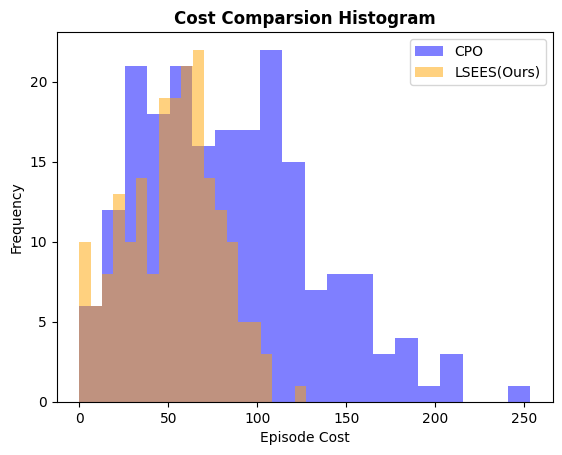

In [35]:
plt.figure()
plt.hist(cost_curve, bins=20, alpha=0.5, label='CPO', color='blue')
# axes[1, 1].hist(act_cost_curve, bins=20, alpha=0.5, label='ActSafe', color='green')
plt.hist(fqi_cost_curve, bins=20, alpha=0.5, label='LSEES(Ours)', color='orange')
plt.title('Cost Comparsion Histogram', fontsize=12, fontweight='bold')
plt.xlabel('Episode Cost')
plt.ylabel('Frequency')
plt.legend()


C:\Users\17913\AppData\Local\Temp\ipykernel_1488\37808932.py:49: UserWarning: Glyph 25104 (\N{CJK UNIFIED IDEOGRAPH-6210}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\17913\AppData\Local\Temp\ipykernel_1488\37808932.py:49: UserWarning: Glyph 26412 (\N{CJK UNIFIED IDEOGRAPH-672C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\17913\AppData\Local\Temp\ipykernel_1488\37808932.py:49: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\17913\AppData\Local\Temp\ipykernel_1488\37808932.py:49: UserWarning: Glyph 24067 (\N{CJK UNIFIED IDEOGRAPH-5E03}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\17913\AppData\Local\Temp\ipykernel_1488\37808932.py:49: UserWarning: Glyph 30452 (\N{CJK UNIFIED IDEOGRAPH-76F4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\17913\AppData\Local\Temp\ipykernel_1488\37808932.py:49: UserWarning: Glyph 26041 (\N{CJK UNIFIED IDEO

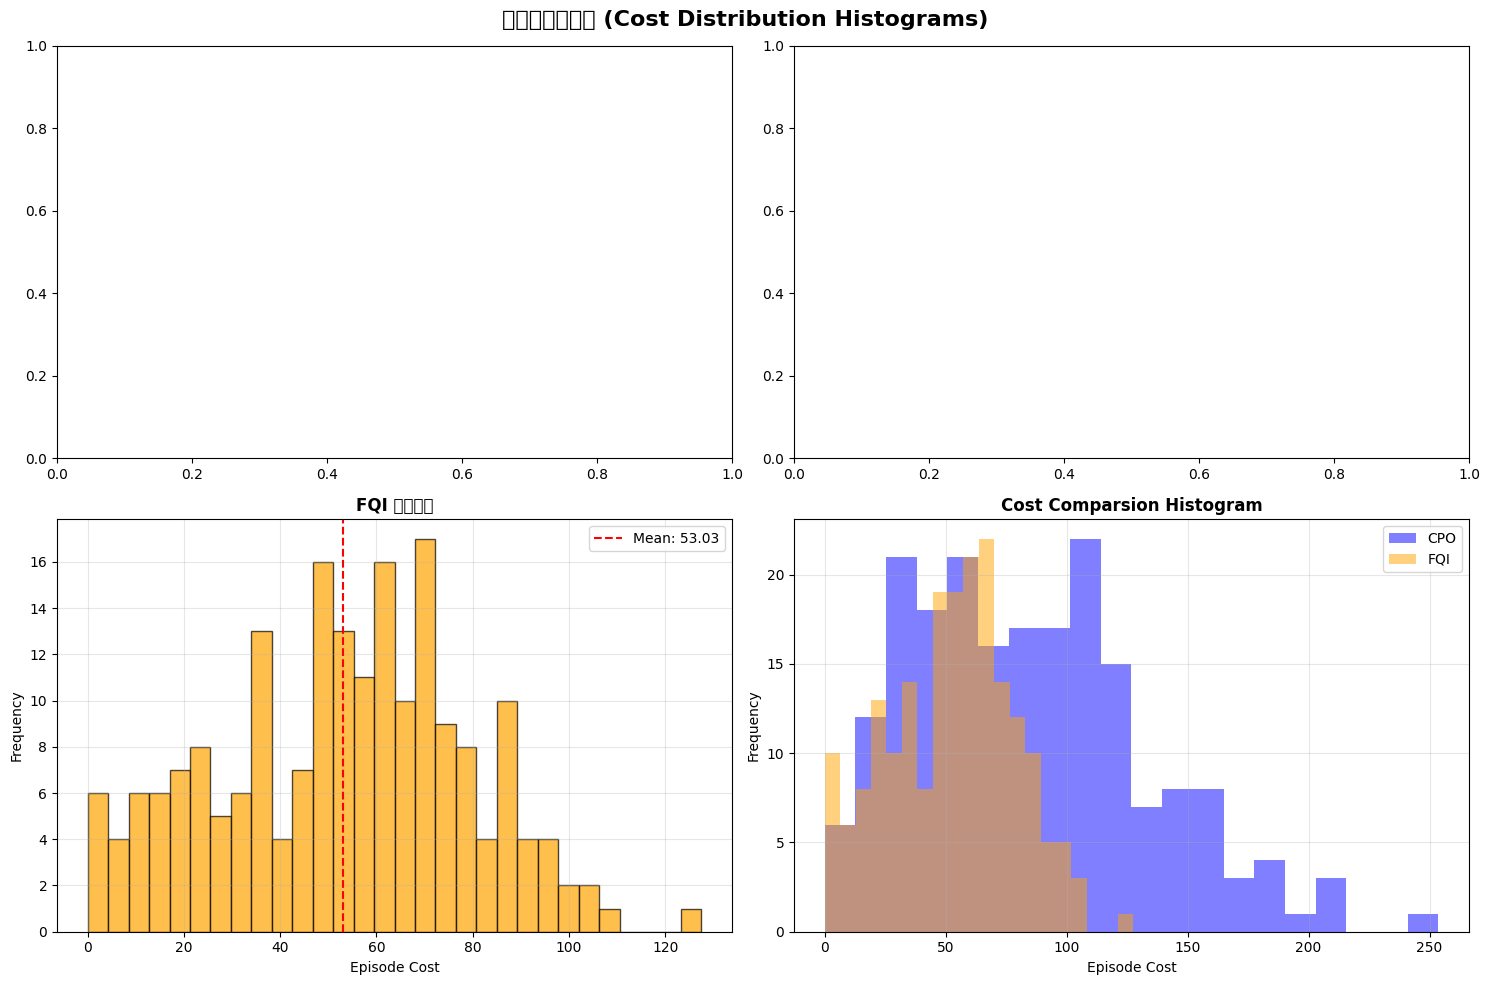

成本统计信息 (Cost Statistics):
CPO:     Mean=84.19, Std=48.47, Min=0.00, Max=253.60
ActSafe: Mean=51.09, Std=26.57, Min=10.40, Max=249.80
FQI:     Mean=53.03, Std=25.80, Min=0.00, Max=127.50


In [36]:
# 直方图 (Histogram) 绘制成本分布
import matplotlib.pyplot as plt
import numpy as np

# 创建子图
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('成本分布直方图 (Cost Distribution Histograms)', fontsize=16, fontweight='bold')

# # 1. CPO 成本直方图
# axes[0, 0].hist(cost_curve, bins=30, alpha=0.7, color='blue', edgecolor='black')
# axes[0, 0].set_title('CPO 成本分布', fontsize=12, fontweight='bold')
# axes[0, 0].set_xlabel('Episode Cost')
# axes[0, 0].set_ylabel('Frequency')
# axes[0, 0].grid(True, alpha=0.3)
# axes[0, 0].axvline(np.mean(cost_curve), color='red', linestyle='--', 
#                    label=f'Mean: {np.mean(cost_curve):.2f}')
# axes[0, 0].legend()

# # 2. ActSafe 成本直方图
# axes[0, 1].hist(act_cost_curve, bins=30, alpha=0.7, color='green', edgecolor='black')
# axes[0, 1].set_title('ActSafe 成本分布', fontsize=12, fontweight='bold')
# axes[0, 1].set_xlabel('Episode Cost')
# axes[0, 1].set_ylabel('Frequency')
# axes[0, 1].grid(True, alpha=0.3)
# axes[0, 1].axvline(np.mean(act_cost_curve), color='red', linestyle='--', 
#                    label=f'Mean: {np.mean(act_cost_curve):.2f}')
# axes[0, 1].legend()

# 3. FQI 成本直方图
axes[1, 0].hist(fqi_cost_curve, bins=30, alpha=0.7, color='orange', edgecolor='black')
axes[1, 0].set_title('FQI 成本分布', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Episode Cost')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].axvline(np.mean(fqi_cost_curve), color='red', linestyle='--', 
                   label=f'Mean: {np.mean(fqi_cost_curve):.2f}')
axes[1, 0].legend()

# 4. 所有算法对比直方图
axes[1, 1].hist(cost_curve, bins=20, alpha=0.5, label='CPO', color='blue')
# axes[1, 1].hist(act_cost_curve, bins=20, alpha=0.5, label='ActSafe', color='green')
axes[1, 1].hist(fqi_cost_curve, bins=20, alpha=0.5, label='FQI', color='orange')
axes[1, 1].set_title('Cost Comparsion Histogram', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Episode Cost')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 打印统计信息
print("成本统计信息 (Cost Statistics):")
print("=" * 50)
print(f"CPO:     Mean={np.mean(cost_curve):.2f}, Std={np.std(cost_curve):.2f}, Min={np.min(cost_curve):.2f}, Max={np.max(cost_curve):.2f}")
print(f"ActSafe: Mean={np.mean(act_cost_curve):.2f}, Std={np.std(act_cost_curve):.2f}, Min={np.min(act_cost_curve):.2f}, Max={np.max(act_cost_curve):.2f}")
print(f"FQI:     Mean={np.mean(fqi_cost_curve):.2f}, Std={np.std(fqi_cost_curve):.2f}, Min={np.min(fqi_cost_curve):.2f}, Max={np.max(fqi_cost_curve):.2f}")
